In [1]:
import numpy as np
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

\begin{array}{|l|l|l|}
\hline ID & Test name & Description \\
\hline 1 & \text { Fixed (0.0) } & \text { Top wheel 0, Yaw target 0 } \\
\hline 2 & \text { Fixed (0.0) } & \text { Top wheel 0, Yaw target 0 } \\
\hline 3 & \text { Fixed (6.0) } & \text { Top wheel 6, Yaw target 0 } \\
\hline 4 & \text { Fixed (-6.0) } & \text { Top wheel -6, Yaw target 0 } \\
\hline 5 & \text { Fixed (9.0) } & \text { Top wheel 9, Yaw target 0 } \\
\hline 6 & \text { Fixed (-9.0) } & \text { Top wheel -9, Yaw target 0 } \\
\hline 7 & \text { Fixed (0.5) } & \text { Top wheel 0, Yaw target 3 } \\
\hline 8 & \text { Fixed (0.-5) } & \text { Top wheel 0, Yaw target -3 } \\
\hline 9 & \text { Fixed (-6.-5) } & \text { Top wheel -6, Yaw target -3 } \\
\hline
\end{array}

All tests are done with constant X-velocity: 0.05 m/s

In [2]:
# Load experiment data
b_exp1 = bagreader('rosbag_exp/secondary_2023-04-21-11-52-45_0.bag')
b_exp2 = bagreader('rosbag_exp/secondary_2023-04-21-13-59-49_0.bag')

[INFO]  Data folder rosbag_exp/secondary_2023-04-21-11-52-45_0 already exists. Not creating.
[INFO]  Data folder rosbag_exp/secondary_2023-04-21-13-59-49_0 already exists. Not creating.


In [3]:
LE_EXP1 = b_exp1.message_by_topic('/ackermann/robot_actual_le_dist')
VEL_EXP1 = b_exp1.message_by_topic('/rope_drive/encoder_velocity')
IMU_EXP1 = b_exp1.message_by_topic('/imu/processed_data')
LEFT_WHEEL_EXP1 = b_exp1.message_by_topic('/rr_wheels/left_wheel_status')
RIGHT_WHEEL_EXP1 = b_exp1.message_by_topic('/rr_wheels/right_wheel_status')

LE_EXP2 = b_exp2.message_by_topic('/ackermann/robot_actual_le_dist')
VEL_EXP2 = b_exp2.message_by_topic('/rope_drive/encoder_velocity')
IMU_EXP2 = b_exp2.message_by_topic('/imu/processed_data')
LEFT_WHEEL_EXP2 = b_exp2.message_by_topic('/rr_wheels/left_wheel_status')
RIGHT_WHEEL_EXP2 = b_exp2.message_by_topic('/rr_wheels/right_wheel_status')

df_le_dist_exp1 = pd.read_csv(LE_EXP1)
df_vel_exp1 = pd.read_csv(VEL_EXP1)
df_imu_exp1 = pd.read_csv(IMU_EXP1)
df_left_wheel_exp1 = pd.read_csv(LEFT_WHEEL_EXP1)
df_right_wheel_exp1 = pd.read_csv(RIGHT_WHEEL_EXP1)

df_le_dist_exp2 = pd.read_csv(LE_EXP2)
df_vel_exp2 = pd.read_csv(VEL_EXP2)
df_imu_exp2 = pd.read_csv(IMU_EXP2)
df_left_wheel_exp2 = pd.read_csv(LEFT_WHEEL_EXP2)
df_right_wheel_exp2 = pd.read_csv(RIGHT_WHEEL_EXP2)

df_le_dist_exp = df_le_dist_exp1.append(df_le_dist_exp2)
df_vel_exp = df_vel_exp1.append(df_vel_exp2)
df_imu_exp = df_imu_exp1.append(df_imu_exp2)
df_left_wheel_exp = df_left_wheel_exp1.append(df_left_wheel_exp2)
df_right_wheel_exp = df_right_wheel_exp1.append(df_right_wheel_exp2)

df_yaw_exp = df_imu_exp[['Time', 'euler_angles.yaw']]
df_left_steer_exp = df_left_wheel_exp[['Time', 'angle']]
df_right_steer_exp = df_right_wheel_exp[['Time', 'angle']]

In [4]:
test_starts= [datetime.datetime(2023, 4, 21, 11, 57, 57, 876955),
datetime.datetime(2023, 4, 21, 12, 3, 39, 390199),
datetime.datetime(2023, 4, 21, 14, 1, 24, 971827),
datetime.datetime(2023, 4, 21, 14, 4, 17, 643814),
datetime.datetime(2023, 4, 21, 14, 14, 9, 108547),
datetime.datetime(2023, 4, 21, 14, 20, 0, 476324),
datetime.datetime(2023, 4, 21, 14, 30, 17, 676489),
datetime.datetime(2023, 4, 21, 14, 37, 12, 897836),
datetime.datetime(2023, 4, 21, 14, 39, 58, 685622)]

test_ends= [datetime.datetime(2023, 4, 21, 11, 58, 31, 82865),
datetime.datetime(2023, 4, 21, 12, 4, 4, 175171),
datetime.datetime(2023, 4, 21, 14, 1, 45, 605403),
datetime.datetime(2023, 4, 21, 14, 5, 27, 331267),
datetime.datetime(2023, 4, 21, 14, 14, 22, 715292),
datetime.datetime(2023, 4, 21, 14, 21, 41, 627971),
datetime.datetime(2023, 4, 21, 14, 30, 37, 816596),
datetime.datetime(2023, 4, 21, 14, 37, 48, 143187),
datetime.datetime(2023, 4, 21, 14, 41, 38, 841980)]

In [5]:
# Get data from experiment date times
year = 2023
month = 4
day = 21

def df_time_span(t_start, t_end, df):

    t_start = time.mktime(t_start.timetuple())
    t_end = time.mktime(t_end.timetuple())
    
    df_timed = df[(df.Time >= t_start) & (df.Time <= t_end)].copy()

    df_timed['Time'] = df_timed['Time'] - t_start

    return df_timed

# Plot vel, yaw, le_dist
def df_plot_exp(t_start, t_end, df_vel, df_yaw, df_le_dist, df_left_steer, df_right_steer, title=''):

    df_vel_timed =  df_time_span(t_start, t_end, df_vel)
    df_yaw_timed = df_time_span(t_start, t_end, df_yaw)
    df_le_dist_timed = df_time_span(t_start, t_end, df_le_dist)
    df_left_steer_timed = df_time_span(t_start, t_end, df_left_steer)
    df_right_steer_timed = df_time_span(t_start, t_end, df_right_steer)

    df_vel_timed['data'] = -df_vel_timed['data']
    df_ypos_timed = df_le_dist_timed
    df_ypos_timed['data'] = -(df_ypos_timed['data'] - df_ypos_timed['data'].iat[0])

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8,8), sharex=True)

    df_vel_timed.plot(ylim=[-0.01, 0.13], x='Time', xlabel='Time [s]', y='data', ylabel='x-velocity [m/s]', grid=True, legend=False, ax=axes[0], title=title)
    df_yaw_timed.plot(x='Time', xlabel='Time [s]', y='euler_angles.yaw', ylabel='Yaw [$^\circ$]', grid=True, legend=False, ax=axes[1])
    df_left_steer_timed.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='angle', ylabel='Steering LE [$^\circ$]', grid=True, legend=False, ax=axes[2])
    df_right_steer_timed.plot(ylim=[-10, 10], x='Time', xlabel='Time [s]', y='angle', ylabel='Steering TE [$^\circ$]', grid=True, legend=False, ax=axes[3])
    df_ypos_timed.plot(x='Time', xlabel='Time [s]', y='data', ylabel='y-position [m]', grid=True, legend=False, ax=axes[4])

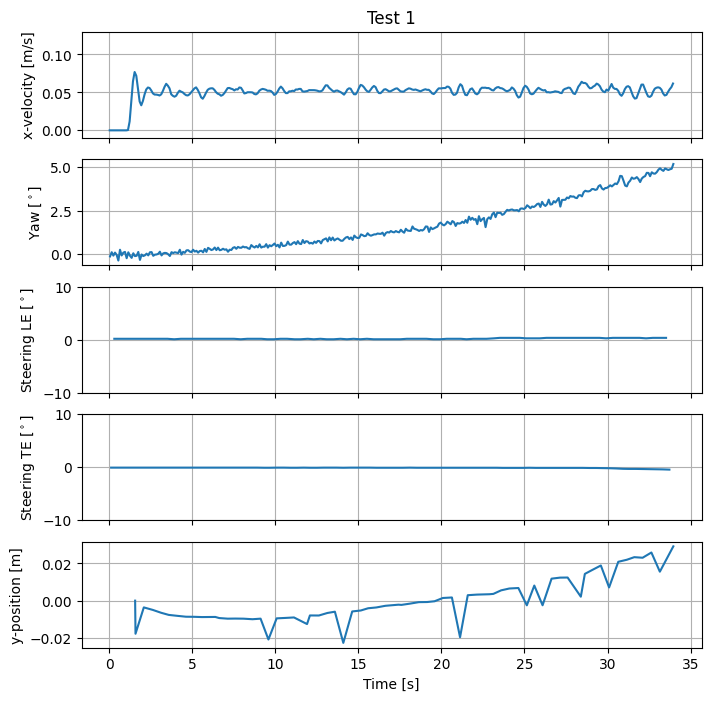

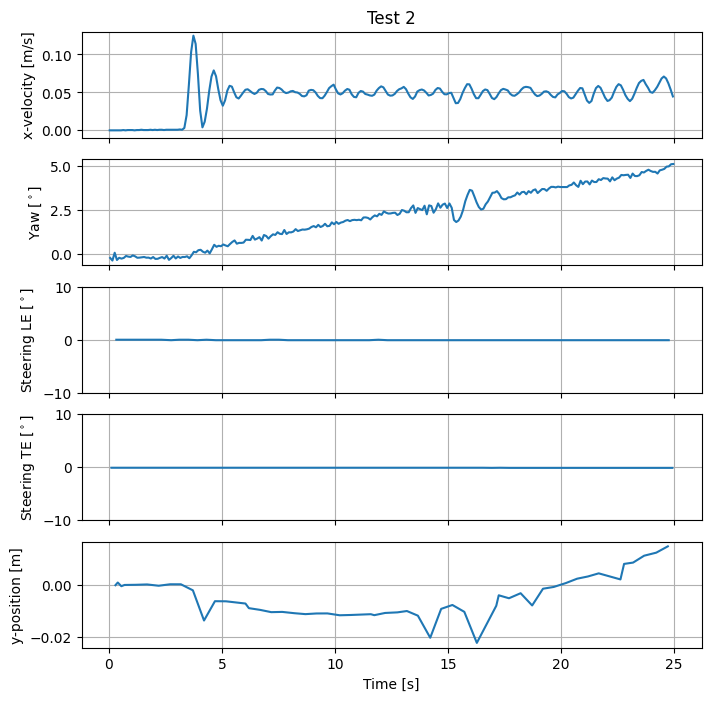

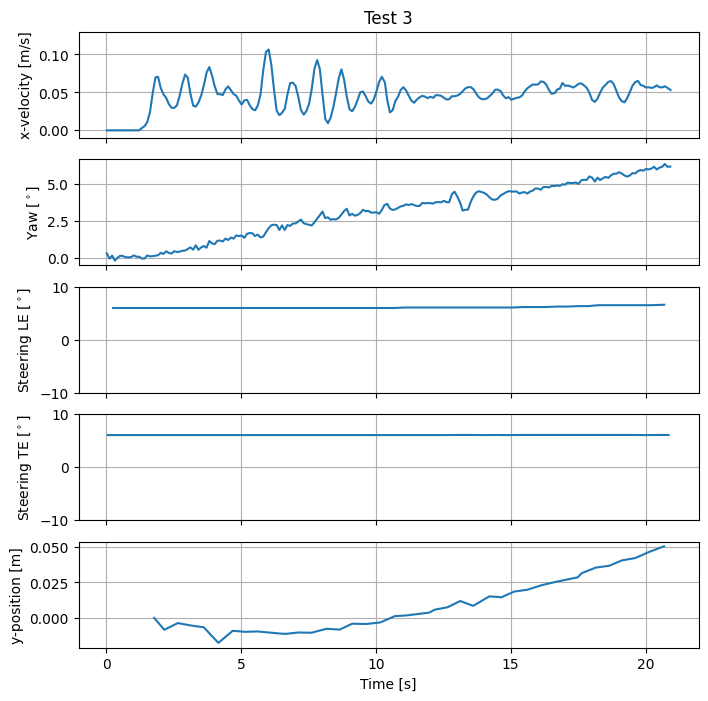

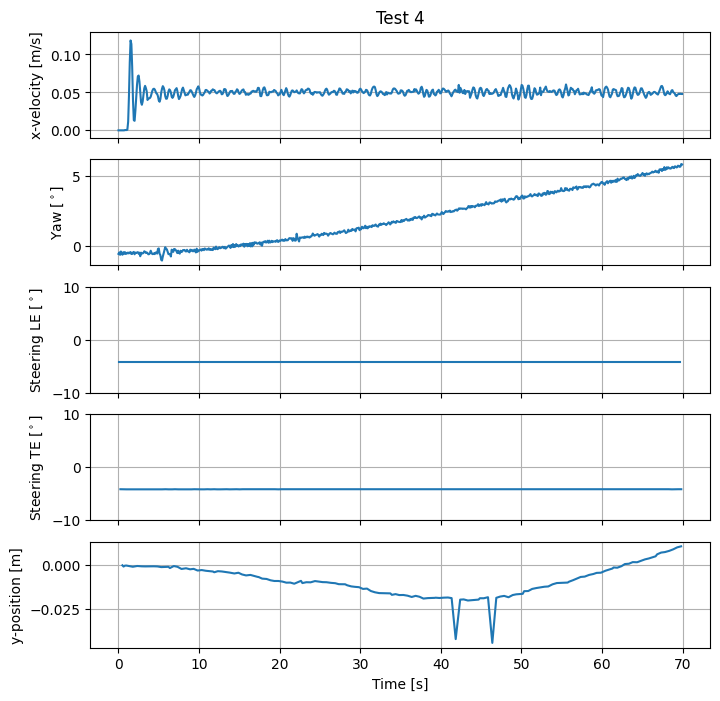

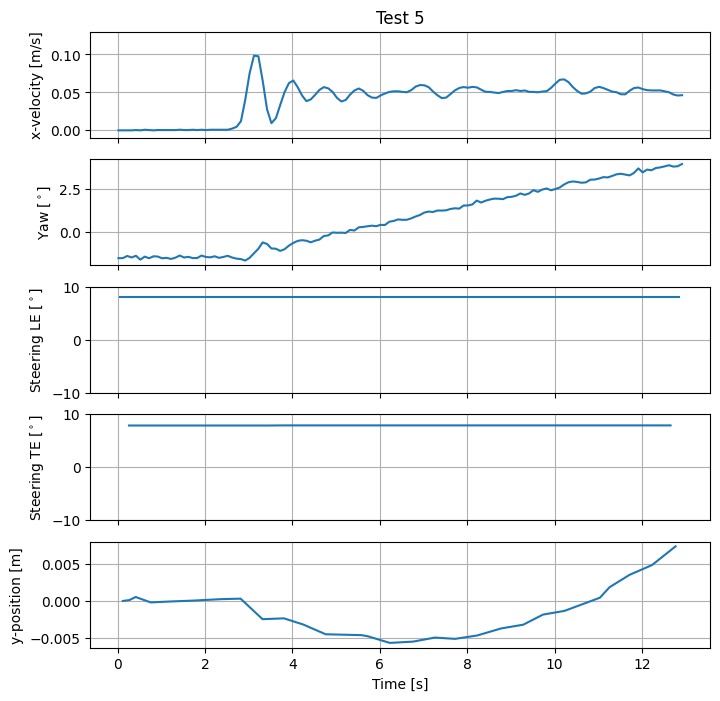

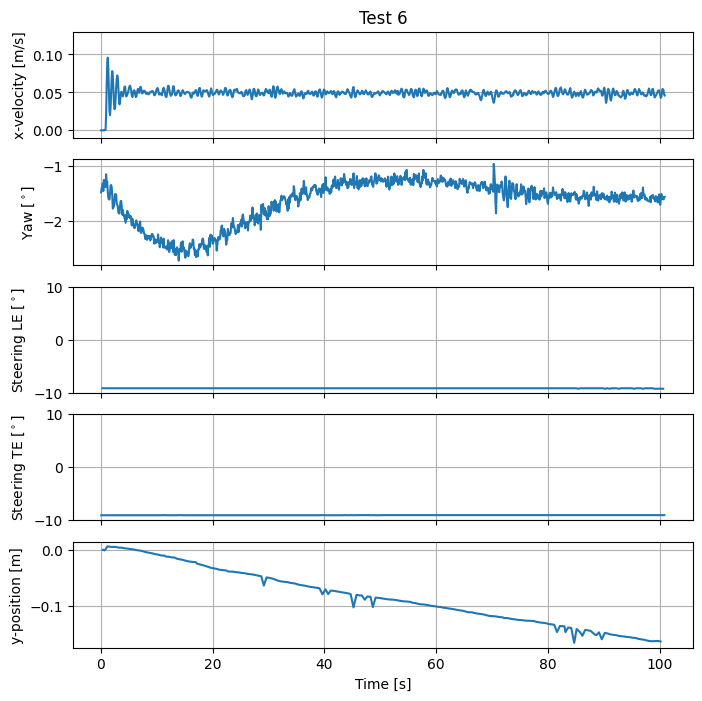

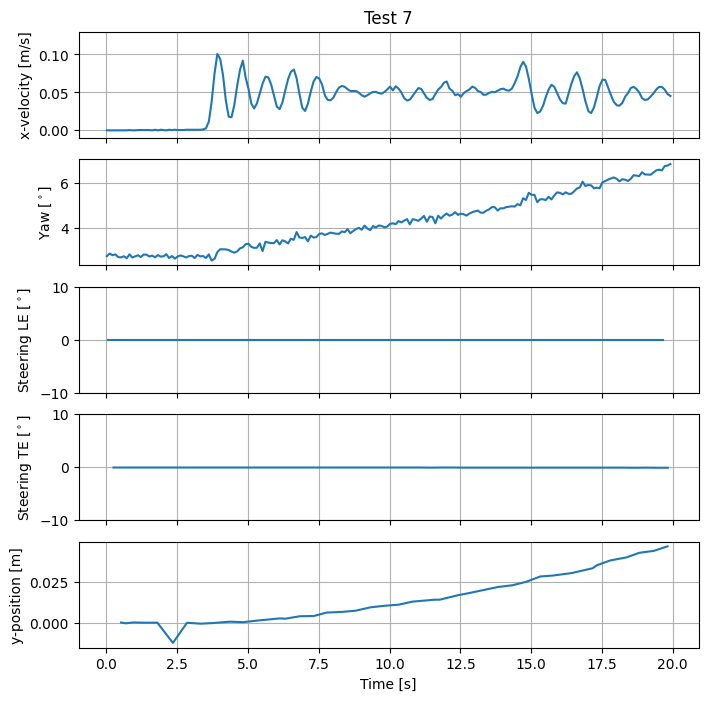

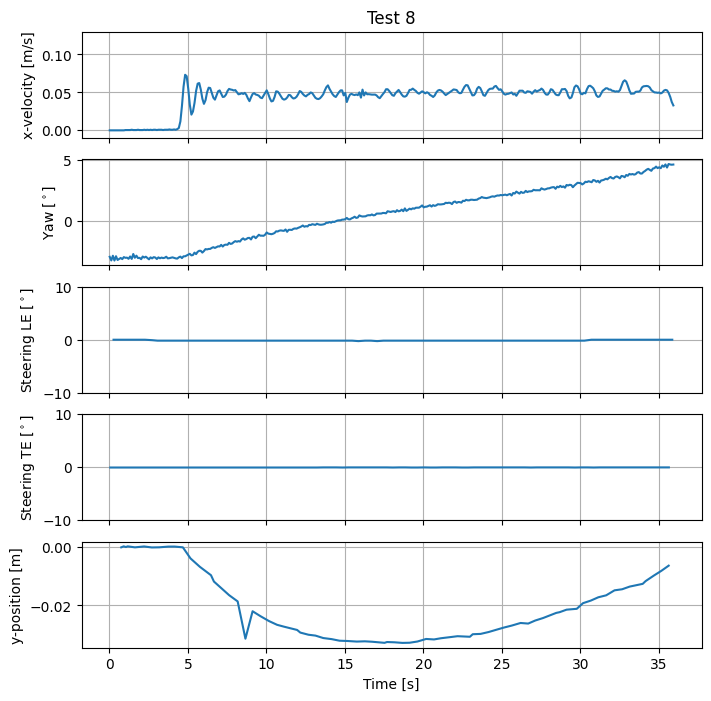

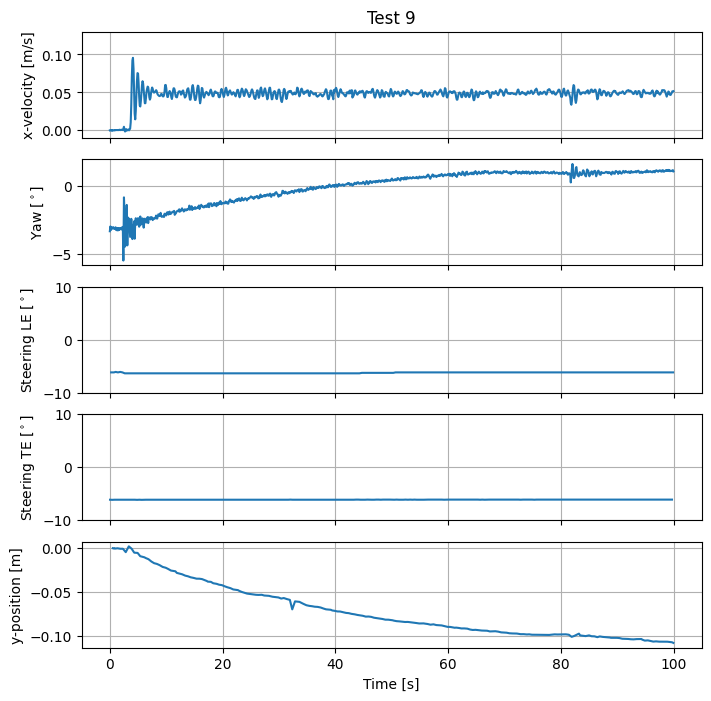

In [6]:
for i in range(0,9):
    df_plot_exp(test_starts[i], test_ends[i], df_vel_exp, df_yaw_exp, df_le_dist_exp, df_left_steer_exp, df_right_steer_exp, title=f'Test {i+1}')
    plt.savefig(f'plots/test{i+1}.png', bbox_inches='tight')